In [1]:
import sigtech.framework as sig
import numpy as np
import pandas as pd
import datetime as dtm
import seaborn as sns

sns.set(rc={'figure.figsize': (18, 6)})

from sigtech.framework.default_strategy_objects.rolling_futures import cl_comdty_f_0
from sigtech.framework.signal.library.momentum import simple_ma_signal, ma

sig.init()

SigTech environment successfully initialized


In [2]:
rfs = sig.RollingFutureStrategy(
    currency='USD',
    initial_cash=1,
    start_date=dtm.date(2010, 1, 4),
    # end_date=dtm.date(2021, 11, 30),
    contract_code='CL',
    contract_sector='COMDTY',
    rolling_rule='front',
    front_offset='-3:-2',
    fixed_contracts=1
)

In [3]:
cl = cl_comdty_f_0()
cl_price_history = cl_comdty_f_0().history()

## WMA Function

In [4]:
def wma(window, ts, weighting='linear'):
    # Convert to a Pandas Series if it's not already
    if not isinstance(ts, pd.Series):
        ts = pd.Series(ts)

    # Define a function to calculate the linear weighted mean
    def linear_weighted_mean(data):
        weights = np.arange(1, window + 1)
        return np.sum(data * weights) / np.sum(weights)

    # Define a function to calculate the exponential weighted mean
    def exponential_weighted_mean(data):
        weights = np.exp(np.linspace(-1, 0, window))
        return np.sum(data * weights) / np.sum(weights)

    # Choose the weighting function based on the parameter
    if weighting == 'linear':
        weighted_mean_function = linear_weighted_mean
    elif weighting == 'exponential':
        weighted_mean_function = exponential_weighted_mean
    else:
        raise ValueError("Invalid weighting type. Choose 'linear' or 'exponential'.")

    # Apply the chosen weighted mean function over the rolling window
    return ts.rolling(window=window).apply(weighted_mean_function, raw=False)


## Create a Signal DF

In [5]:
def signal_generation(short_span, long_span, wma_span, df):
    
    short_ma = ma(short_span, df.dropna())
    long_ma = ma(long_span, df.dropna())
    cross_signal = np.sign(simple_ma_signal(short_span, long_span, df.dropna()))
    wma_price = wma(wma_span, df)
    price_history = df

    return pd.DataFrame({
        'short_ma':short_ma, 
        'long_ma':long_ma, 
        'cross_signal':cross_signal, 
        'wma_price':wma_price,
        'price_history': price_history}
    ).dropna()



In [6]:
new_signal_df = signal_generation(6,25,80,rfs.history())
new_signal_df

,short_ma,long_ma,cross_signal,wma_price,price_history
2010-04-28,-543.297788,553.563004,1.0,-1265.981405,-1049.967704
2010-04-29,-294.965899,678.767523,1.0,-1186.586417,900.026463
2010-04-30,113.367370,846.372664,-1.0,-1083.271252,1880.031463
2010-05-03,291.706128,1036.779431,-1.0,-979.547645,1920.061230
2010-05-04,48.377635,1002.388235,-1.0,-961.166078,-1529.928103
...,...,...,...,...,...
2023-08-28,-42070.257127,-41102.085798,1.0,-45044.642059,-41601.075477
2023-08-29,-41905.171348,-41025.691856,1.0,-44882.824223,-40547.200080
2023-08-30,-41581.727931,-40896.498461,1.0,-44713.322503,-40083.169529
2023-08-31,-40799.903562,-40739.697596,1.0,-44497.644808,-38089.070662


In [7]:
signal_df = signal_generation(6,25,80,cl_price_history)
signal_df

,short_ma,long_ma,cross_signal,wma_price,price_history
2010-04-28,990.259840,997.289644,-1.0,973.540021,984.283212
2010-04-29,993.206020,999.236499,-1.0,974.696659,1007.365274
2010-04-30,998.045680,1001.685363,-1.0,976.137520,1018.968339
2010-05-03,1000.165258,1004.405828,-1.0,977.584613,1019.457838
2010-05-04,997.437443,1004.494953,-1.0,978.041677,979.502836
...,...,...,...,...,...
2023-08-28,479.445737,484.299060,-1.0,459.229226,482.712708
2023-08-29,480.580940,484.861589,-1.0,460.312941,489.150008
2023-08-30,482.667241,485.739343,-1.0,461.442269,492.044786
2023-08-31,487.506545,486.786350,1.0,462.848269,504.128987


In [8]:
def signal_function(row):
    if row['cross_signal'] > 0:
        return 1 if row['price_history'] > row['wma_price'] else 0
    else:
        return 0 if row['price_history'] > row['wma_price'] else -1    
    

In [9]:
trade_df = new_signal_df.apply(signal_function,axis=1).to_frame(rfs.name)
trade_df = trade_df[trade_df!=trade_df.shift()].dropna()
trade_df

,USD CL COMDTY LONG FRONT 1080CE49 RFS STRATEGY
2010-04-28,1.0
2010-04-30,0.0
2010-05-04,-1.0
2010-05-05,0.0
2010-06-15,-1.0
...,...
2023-04-26,0.0
2023-07-06,-1.0
2023-07-07,0.0
2023-08-22,1.0


In [10]:
trade_df = signal_df.apply(signal_function,axis=1).to_frame(cl.name)
trade_df = trade_df[trade_df!=trade_df.shift()].dropna()
trade_df

,USD CL COMDTY LONG F_0 RF STRATEGY
2010-04-28,0.0
2010-05-05,-1.0
2010-06-15,0.0
2010-07-02,-1.0
2010-07-20,0.0
...,...
2023-06-12,-1.0
2023-07-05,0.0
2023-07-07,1.0
2023-08-23,0.0


<AxesSubplot:>

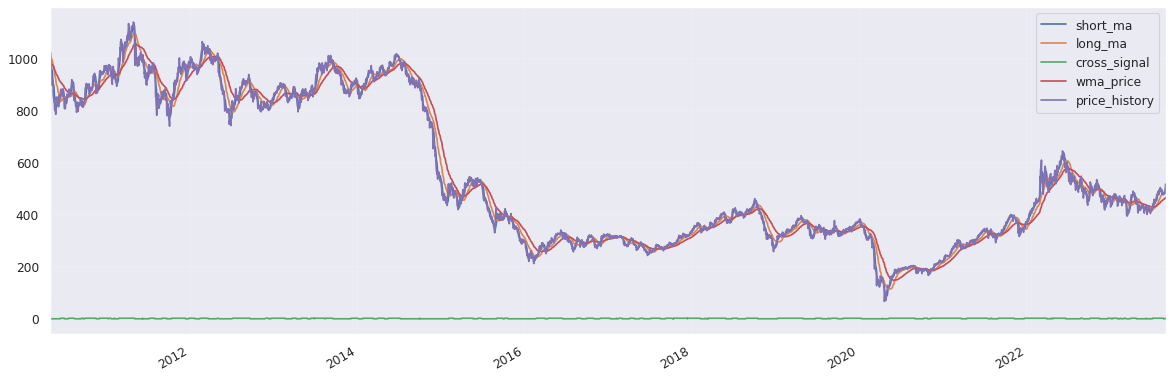

In [11]:
signal_df.plot()

In [13]:
strategy = sig.SignalStrategy(
    currency='USD',
    signal_name=sig.signal_library.from_ts(trade_df).name,
    # start_date=dtm.date(2015, 1, 4),
    use_signal_for_rebalance_dates=True,
    # execution_time_input=dtm.time(16,0),
    # execution_timezone_input=pytz.utc,
)

In [ ]:
strategy.inspect.trade_timings_df()

In [ ]:
def plot_trade_chart(strategy_object, signal_df):
   
    signal_df = signal_df[strategy_object.start_date:sig.env().asofdate]
    signal_df = signal_df.dropna()
    
    # Plot chart
    import plotly.io as pio
    import plotly.graph_objects as go
    
    pio.renderers.default='iframe'

    line_price = go.Scatter(x=signal_df.index, y=signal_df['price_history'], mode='lines', name='Price')
    line_wma = go.Scatter(x=signal_df.index, y=signal_df['wma_price'], mode='lines', name='WMA Price')
    line_ma_short = go.Scatter(x=signal_df.index, y=signal_df['short_ma'], mode='lines', name='short_ma Price') 
    line_ma_long = go.Scatter(x=signal_df.index, y=signal_df['long_ma'], mode='lines', name='long_ma Price')
    # line_strategy = go.Scatter(x=strategy_object.history().index, y=strategy_object.history(), mode='lines', name='Strategy Performance')
    fig = go.Figure(data=[line_price, 
                          line_wma, 
                          line_ma_short, 
                          line_ma_long, 
                          # line_strategy
                         ])

    fig.show()

In [ ]:
plot_trade_chart(strategy, signal_df)